# fMRI Demo

## Introduction

This is an example of RSA on a BIDS-structured fMRI dataset. This study is still under review, so we will update this demo to include steps to download the data when it becomes publicly available. 

Participants (n=14) viewed images of 16 objects, as well as their written name. Several properties of the stimuli were carefully balanced. They also performed several tasks, but for the purposes of this demo we will ignore these.

![stimuli](demo_fmri_files/mur32_stims.png)

This library depends on *nibabel* for convenience functions to access MRI data, and is used separately in the demo as well, so start by installing nibabel (`pip install nibabel`).

Then run the following imports:

In [1]:
%matplotlib inline
from os.path import expanduser
from rsatoolbox.io.fmriprep import find_fmriprep_runs, make_design_matrix
from rsatoolbox.data.dataset import Dataset, merge_datasets
from rsatoolbox.vis import show_rdm
from rsatoolbox.rdm.calc import calc_rdm
from rsatoolbox.data.noise import prec_from_residuals, prec_from_measurements
import numpy, pandas, matplotlib.pyplot

Now we define the path to the BIDS-root data directory

In [2]:
data_dir = expanduser('~/data/rsatoolbox/mur32')

Next we use a utility function to find the relevant preprocessed BOLD images:

In [3]:
runs = find_fmriprep_runs(data_dir, tasks=['main'])
len(runs)

84

As with most real-world datasets, this one has some unplanned idiosyncrasies; subject 02 is missing some data, and to keep this demo straightforward, we will remove subject 02 from the analysis:

In [4]:
runs = [run for run in runs if run.boldFile.sub != '02']
len(runs)

78

Each run object carries the relevant data and metadata

In [5]:
run = runs[0]
run

<FmriprepRun [sub-13/ses-02/func/sub-13_ses-02_task-main_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz]>

In [6]:
dims = run.get_data().shape ## bold timeseries: x * y * z * volumes
n_vols = dims[-1]
dims

(65, 77, 55, 546)

Access the attributes stored in the *_metadata.json* for this file

In [7]:
tr = run.get_meta()['RepetitionTime'] ## TR in seconds
tr

2

We will also load the events table

In [8]:
run.get_events().sample(5) ## 5 random events

,onset,duration,trial_type,modality,identity,response_time,task,response_mapping
231,692.995,0.5,text_spade,text,spade,1.062,fixation,right-left
78,233.988,0.5,image_pedal,image,pedal,0.960,fixation,left-right
190,569.982,0.5,text_candle,text,candle,0.893,visual,right-left
188,563.996,0.5,baseline,NaN,NaN,NaN,NaN,NaN
157,470.995,0.5,baseline,NaN,NaN,NaN,NaN,NaN


In [9]:
run.get_confounds().head(3)

,global_signal,csf,white_matter,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,477.173160,721.191587,468.253287,0.097748,0.103464,0.150696,0.000077,0.000504,0.000718
1,481.804458,713.048937,468.591408,-0.008263,-0.055221,-0.093955,0.002140,0.001353,-0.000761
2,478.581165,705.795645,466.171710,0.028462,0.048614,0.059355,0.001037,0.000317,0.000058


## Patterns

Next we want to establish Multi-Voxel Patterns from the timeseries, such that, for each stimulus presentation, we have one observation per voxel. The most common way to do this is with a General Linear Model, where each predictor in the model reflects one type of event, convolved with the haemodynamic response function (HRF). For the purposes of this demo we will use a very basic glm implementation in Python. For a guide on MVPA, see [Mur et al. 2009](https://doi.org/10.1093/scan/nsn044).

First we use a utility function which creates predictors from the events table and convolves them with the HRF. Note that we have 34 predictors, with a value for each volume in the BOLD timeseries. The smooth line that appears in the first ~70 timepoints is a side effect of the conditions being sorted according to their first occurrence.

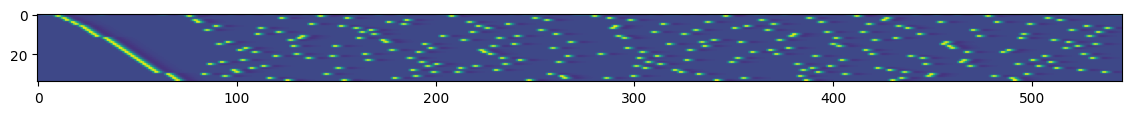

In [10]:
fig=matplotlib.pyplot.figure(figsize=(14,8))
dm, exp_preds, dof = make_design_matrix(run.get_events(), tr, n_vols, run.get_confounds())
matplotlib.pyplot.imshow(dm[:, exp_preds].T)

Then we define our GLM function

In [11]:
def simple_glm(data, dm):
    data = data.reshape(-1, data.shape[-1])
    data = data / data.mean(axis=0)
    X = numpy.linalg.inv(dm.T @ dm) @ dm.T
    betas = X @ data.T
    resids = data - (betas.T @ X)
    return betas, (resids**2).T

When we apply this to the first run we get the following pattern array

In [12]:
patterns, mse = simple_glm(run.get_data(), dm)
patterns[exp_preds].shape, mse.shape

((34, 275275), (546, 275275))

The run object then provides us with dictionaries with attributes that identify this run and its various dimensions. These map unto the rsatoolbox *descriptors*.

In [13]:
run.to_descriptors(collapse_by_trial_type=True)

{'descriptors': {'sub': '13', 'ses': '02', 'run': '03', 'task': 'main'},
 'obs_descriptors': {'trial_type': array(['baseline', 'instruction', 'text_candle', 'text_kettle',
         'image_candle', 'text_knife', 'text_glove', 'text_table',
         'image_ladder', 'text_wheel', 'text_saddle', 'text_clock',
         'text_glass', 'text_bagel', 'image_clock', 'image_table',
         'image_knife', 'image_brick', 'image_bagel', 'image_wheel',
         'text_ladder', 'image_pedal', 'text_brick', 'text_pedal',
         'text_spade', 'image_helmet', 'image_glass', 'text_sponge',
         'text_helmet', 'image_glove', 'image_spade', 'image_sponge',
         'image_kettle', 'image_saddle'], dtype=object)},
 'channel_descriptors': {'aparcaseg': array(['Unknown', 'Unknown', 'Unknown', ..., 'Unknown', 'Unknown',
         'Unknown'], dtype=object)}}

We can then combine the patterns and descriptors to create an rsatoolbox `Dataset` object

In [14]:
Dataset(
    measurements=patterns[exp_preds],
    descriptors=run.get_dataset_descriptors(),
    obs_descriptors=run.get_obs_descriptors(collapse_by_trial_type=True),
    channel_descriptors=run.get_channel_descriptors()
)

rsatoolbox.data.Dataset(
measurements = 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
descriptors = 
{'sub': '13', 'ses': '02', 'run': '03', 'task': 'main'}
obs_descriptors = 
{'trial_type': array(['baseline', 'instruction', 'text_candle', 'text_kettle',
       'image_candle', 'text_knife', 'text_glove', 'text_table',
       'image_ladder', 'text_wheel', 'text_saddle', 'text_clock',
       'text_glass', 'text_bagel', 'image_clock', 'image_table',
       'image_knife', 'image_brick', 'image_bagel', 'image_wheel',
       'text_ladder', 'image_pedal', 'text_brick', 'text_pedal',
       'text_spade', 'image_helmet', 'image_glass', 'text_sponge',
       'text_helmet', 'image_glove', 'image_spade', 'image_sponge',
       'image_kettle', 'image_saddle'], dtype=object)}
channel_descriptors = 
{'aparcaseg': array(['Unknown', 'Unknown', 'Unknown', ..., 'Unknown', 'Unknown',
       'Unkn

Let's repeat this for the other runs: (takes about 4mins). Along the way we also store the MSE residuals for each run.

In [15]:
run_datasets = []
run_noise_sets = []
for run in runs:
    dm, exp_preds, dof = make_design_matrix(run.get_events(), tr, n_vols, run.get_confounds())
    patterns, mse = simple_glm(run.get_data(), dm)
    run_datasets.append(
        Dataset(
            measurements=patterns[exp_preds],
            descriptors=run.get_dataset_descriptors(),
            obs_descriptors=run.get_obs_descriptors(collapse_by_trial_type=True),
            channel_descriptors=run.get_channel_descriptors()
        )
    )
    run_noise_sets.append(
        Dataset(
            measurements=mse,
            descriptors=run.get_dataset_descriptors(),
            channel_descriptors=run.get_channel_descriptors()
        )
    )
len(run_datasets)

78

In [19]:
run_noise_sets[0].measurements.nbytes / 1024**3

1.119823381304741

In [1]:
run_noise_sets[0]

NameError: name 'run_noise_sets' is not defined

Then we combine the run-wise `Dataset` objects into one for the whole experiment (it's several gigabytes in size)

In [22]:
ds = merge_datasets(run_datasets)
noise_ds = merge_datasets(run_noise_sets)
print(f'{(ds.measurements.nbytes / 1024**3):.1f}GB')
run_noise_sets[0].nbytes / 1024**3

: 

## Calculate data RDMs

Let's remove the *baseline* and *instruction* conditions as they are not relevant for our RSA approach:

In [ ]:
all_conds = numpy.unique(ds.obs_descriptors['trial_type'])
object_conds = [c for c in all_conds if c not in ('baseline', 'instruction')]
ds = ds.subset_obs('trial_type', object_conds)
numpy.unique(ds.obs_descriptors['trial_type']).size

32

Next we focus on a ROI: The right hemisphere IT as provided by the cortical parcellation *aparc*

In [ ]:
ds = ds.subset_channel('aparcaseg', 'ctx-rh-inferiortemporal')
noise_ds = noise_ds.subset_channel('aparcaseg', 'ctx-rh-inferiortemporal')
ds.n_channel

530


We will create one RDM for per subject, so that later we can test our hypothesis on the sample.
This splits the dataset into a list of `Dataset` objects:

In [ ]:
subject_datasets = ds.split_obs(by='sub')
subject_noise_sets = noise_ds.split_obs(by='sub')
len(subject_datasets)

13

In [ ]:
subject_datasets[0].measurements.shape

(192, 530)

Calculate the noise precision (with shrinkage) matrix for each subject

In [ ]:
subject_precs = []
for nds in subject_noise_sets:
    subject_precs.append(
        prec_from_residuals(
            nds.measurements,
            dof=-99,
            method='shrinkage_diag'
        )
    )

Then pass this list to `calc_rdm` to compute the crossvalidated mahalanobis or crossnobis dissimilarity:

In [ ]:
data_rdms = calc_rdm(subject_datasets, method='crossnobis', noise=subject_precs, descriptor='trial_type')

Let's plot the participant RDMs.

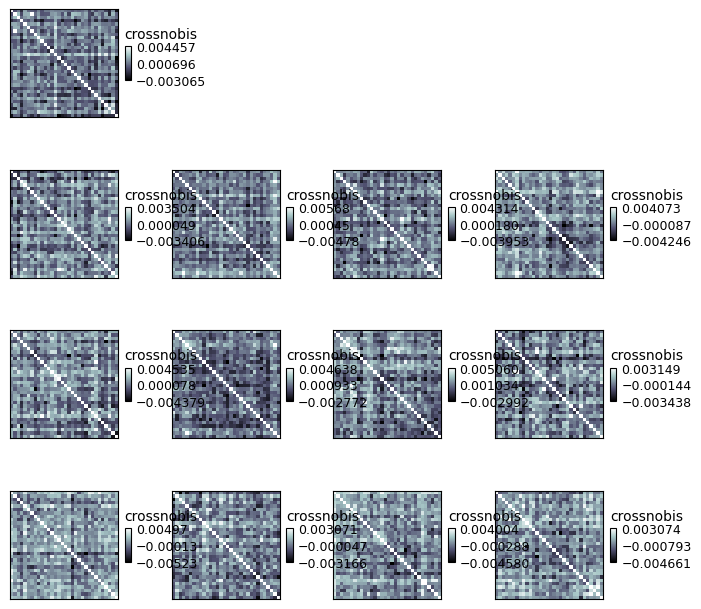

In [ ]:
fig, _, _ = show_rdm(data_rdms, show_colorbar='panel')
matplotlib.pyplot.show()

## Model

Let's map the various stimulus properties of interest on a table

In [ ]:
obj_conds = numpy.unique(ds.obs_descriptors['trial_type']).tolist()
INDOOR = ['bagel', 'candle', 'clock', 'glass', 'kettle', 'knife', 'sponge', 'table']
STRAIGHT = ['candle', 'knife', 'sponge', 'table', 'spade', 'ladder', 'brick', 'pedal']
df = pandas.DataFrame([dict(
    trial_type=c,
    indoor=float(c.split('_')[1] in INDOOR),
    straight=float(c.split('_')[1] in STRAIGHT),
    modality=float('image_' in c)
) for c in obj_conds])
df

,trial_type,indoor,straight,modality
0,image_bagel,1.0,0.0,1.0
1,image_brick,0.0,1.0,1.0
2,image_candle,1.0,1.0,1.0
3,image_clock,1.0,0.0,1.0
4,image_glass,1.0,0.0,1.0
5,image_glove,0.0,0.0,1.0
6,image_helmet,0.0,0.0,1.0
7,image_kettle,1.0,0.0,1.0
8,image_knife,1.0,1.0,1.0
9,image_ladder,0.0,1.0,1.0


We can then turn these into Model RDMs

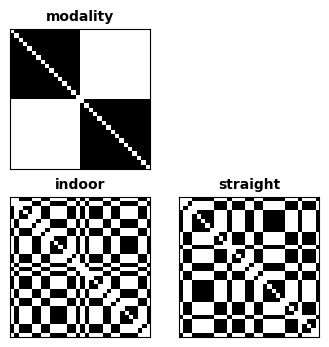

In [ ]:
model_dataset = Dataset.from_df(df)
model_dataset.channel_descriptors
model_rdms = calc_rdm(
    [model_dataset.split_channel('name')],
    method='euclidean',
    descriptor='trial_type'
)
model_rdms.rdm_descriptors['name'] = model_dataset.channel_descriptors['name']
fig, _, _ = show_rdm(model_rdms, rdm_descriptor='name')
matplotlib.pyplot.show()

Next, we wrap each of the model RDMs in their own fixed `Model` object.

In [ ]:
from rsatoolbox.model.model import ModelFixed

models = []
for model_name in model_rdms.rdm_descriptors['name']:
    model_rdm = model_rdms.subset('name', model_name)
    models.append(ModelFixed(model_name, model_rdm))

## Inference

Let's see how well each of these models explains the fMRI data RDMs

In [ ]:
from rsatoolbox.inference.evaluate import eval_bootstrap_rdm

eval_result = eval_bootstrap_rdm(models, data_rdms)
print(eval_result)

100%|██████████| 1000/1000 [00:01<00:00, 716.20it/s]

Results for running bootstrap_rdm evaluation for cosine on 3 models:

Model    |   Eval ± SEM   | p (against 0) | p (against NC) |
------------------------------------------------------------
indoor   |  0.158 ± 0.047 |        0.003  |         0.569  |
straight |  0.141 ± 0.045 |        0.004  |         0.829  |
modality |  0.202 ± 0.047 |      < 0.001  |         0.155  |

p-values are based on uncorrected t-tests


Next let's plot a comparison of the models:

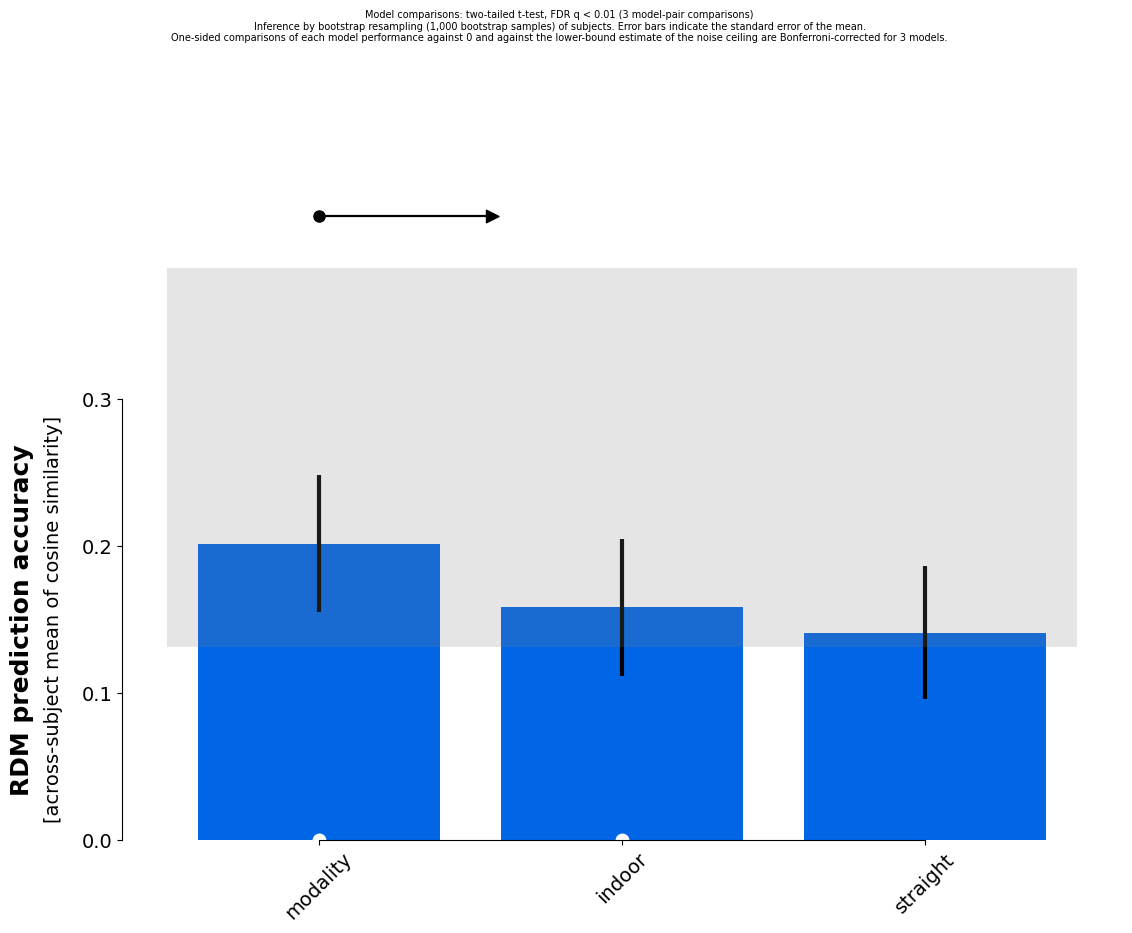

In [ ]:
from rsatoolbox.vis.model_plot import plot_model_comparison

fig, _, _ = plot_model_comparison(eval_result, sort=True)
matplotlib.pyplot.show()